# Case Study 5 : Data Science in OpenAI Games

**Required Readings:** 
* [Deep Reinforcement Learning](http://karpathy.github.io/2016/05/31/rl/) 
* [OpenAI](https://gym.openai.com/)
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.

** NOTE **
* In this case study, you will need to use Mac OS or Linux system. In windows computers, you could use virtualbox to create a virtual machine and install an Ubuntu OS in the virtual machine.
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using OpenAI Games
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the openAI game system and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Using neural network to improve the performance of the agent in pacman

* Algorithm used: Reinforcement Learning - DQN(Deep Q Network)
* Package used: TensorFlow to build the neural network

# Data Collection/Processing: 

In [26]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# The Core of the reinforcement Learning(RL) - DQN

import numpy as np
import pandas as pd
import tensorflow as tf


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
#             print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]
        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]
        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

# Data Exploration: Exploring the OpenAI Game System (Gym)

**1. Playing Pacman** 
We first introduce an example of how to use the gym package from OpenAI to design an agent for Pacman Game.
In the following cell, we implemented a simple agent, which randomly picks the next action without looking at the screen image (i.e., the *observation*) or the reward.

Change the following code for **myAgent** to design a better agent, which takes the observation and reward as the input and picks the best action as the next move.
The agent should be able to improve itself after playing more games.

***The goals***: Implement an agent using neural networks that can achieve all the following goals:
* (a) move the PacMan in all directions.  (5 points)
* (b) using neural network to decide what is the best next move. (5 points)
* (c) after playing each episode of the game, the agent should be able to improve itself using the experience. (5 points)

Action Code:
* 1 - UP
* 2 - RIGHT
* 3 - LEFT
* 4 - DOWN

In [4]:
# Professor's example

import gym
num_episodes = 1 # how many episodes to play
render = True # whether to render the game. You should turn this off to speed up the program.

class myAgent(object):
  def __init__(self,env):
    self.env = env
    pass      
  def pick_next_action(self, observation, reward):
    """ observation is the current screen image. reward is the current reward in the time step """
    best_action = self.env.action_space.sample() # RANDOMLY pick an action for the next move.
    return best_action

        
env = gym.make('MsPacman-v0') # create the game envirement
agent = myAgent(env)# create an agent

# let's play some episodes of the game
for _ in range(num_episodes): 
    observation = env.reset() # initialize the game
    episode_reward=0 # the sum of rewards in an episode
    action = env.action_space.sample() # RANDOMLY pick an action for the next move
    observation, reward, done, info = env.step(action) #execute the action and get the reward and next observation
    while not done: 
        if render: 
            env.render() # render the game
        action = agent.pick_next_action(observation,reward)
        observation, reward, done, info = env.step(action)
        episode_reward += reward #adding up the reward in the episode
        if done: # the episode is done
            print("Episode reward:{}".format(episode_reward))
            episode_reward=0

Episode reward:160.0


Example code for  processing the screen image

(86, 80)


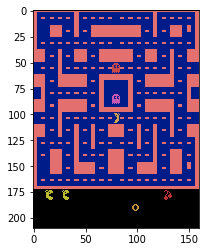

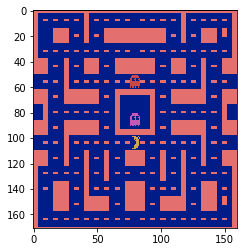

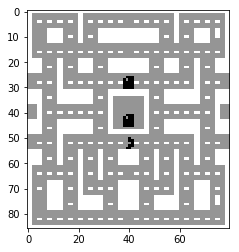

In [4]:
import gym
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

env=gym.make('MsPacman-v0')

observation = env.reset()
observation, reward, done, info = env.step(1)

# plot the current screen
plt.figure(1)
plt.imshow(np.reshape(observation, (210,160,3) ))

#crop the screen
x = np.reshape(observation[0:171], (171,160,3) )
plt.figure(2)
plt.imshow(x)


# remove background
x = x[:,:,1]
x[x==111]=0
x[x==28]=1
x[x>1]=2
# downsample
x=x[::2,::2]
plt.figure(3)
plt.imshow(x,cmap='Greys')
print (x.shape)

In [1]:
# Our code from Here
# PS. Optimized agent code is in the first cell(Choose Action function)

In [2]:
# Transfer the blak and white pic to one line matrix (easy to store in the RL part)

def flatten_bw(observation):
    observation = np.reshape(observation, (210,160,3) )

    #crop the screen
    x = np.reshape(observation[0:171], (171,160,3) )

    # remove background
    x = x[:,:,1]
    x[x==111]=0
    x[x==28]=1
    x[x>1]=2
    # downsample
    x=x[::2,::2]
    x = x.flatten()
#     print(type(x))
#     print (x.shape)
    
    return x

In [3]:
# Train and test the Atari Pacman game

import gym

env = gym.make('MsPacman-v0')
env = env.unwrapped

# print(env.action_space)
# print(env.observation_space)
# print(env.observation_space.high)
# print(env.observation_space.low)

RL = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=6880,
#                   env.observation_space.shape[0],
                  learning_rate=0.01, e_greedy=0.9,
                  replace_target_iter=100, memory_size=2000,
                  e_greedy_increment=0.0001,)

total_steps = 0

reward_list=[]

for i_episode in range(100):

    observation = env.reset()
    observation = flatten_bw(observation)
    ep_r = 0
    while True:
        env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)
        observation_ = flatten_bw(observation_)

        # the smaller theta and closer to center the better
#         print (action)
#         print (reward)
#         print ('observation:',observation)
#         print ('observation_:',observation_)

        RL.store_transition(observation, action, reward, observation_)

        ep_r += reward
        if total_steps > 1000:
            RL.learn()

        if done:
            print('episode: ', i_episode,
                  'ep_r: ', round(ep_r, 2),
                  ' epsilon: ', round(RL.epsilon, 2))
            break

        observation = observation_
        total_steps += 1
    
    reward_list.append(ep_r)

RL.plot_cost()

episode:  0 ep_r:  260.0  epsilon:  0
episode:  1 ep_r:  210.0  epsilon:  0.03
episode:  2 ep_r:  260.0  epsilon:  0.1
episode:  3 ep_r:  320.0  epsilon:  0.16
episode:  4 ep_r:  280.0  epsilon:  0.23
episode:  5 ep_r:  210.0  epsilon:  0.28
episode:  6 ep_r:  190.0  epsilon:  0.34
episode:  7 ep_r:  240.0  epsilon:  0.4
episode:  8 ep_r:  400.0  epsilon:  0.49
episode:  9 ep_r:  260.0  epsilon:  0.57
episode:  10 ep_r:  260.0  epsilon:  0.64
episode:  11 ep_r:  200.0  epsilon:  0.7
episode:  12 ep_r:  380.0  epsilon:  0.77
episode:  13 ep_r:  290.0  epsilon:  0.84
episode:  14 ep_r:  510.0  epsilon:  0.9
episode:  15 ep_r:  360.0  epsilon:  0.9
episode:  16 ep_r:  510.0  epsilon:  0.9
episode:  17 ep_r:  80.0  epsilon:  0.9
episode:  18 ep_r:  640.0  epsilon:  0.9
episode:  19 ep_r:  260.0  epsilon:  0.9
episode:  20 ep_r:  140.0  epsilon:  0.9
episode:  21 ep_r:  270.0  epsilon:  0.9
episode:  22 ep_r:  450.0  epsilon:  0.9
episode:  23 ep_r:  390.0  epsilon:  0.9
episode:  24 ep_r: 

<Figure size 640x480 with 1 Axes>

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

* Solved the problem using the reinforcement learning - DQN











Write codes to implement the solution in python:

In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary



# The solution code is the same as the code in the data collection part, learning in training

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


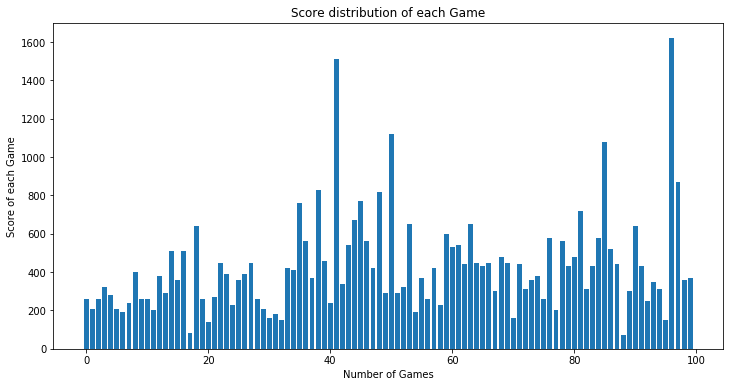

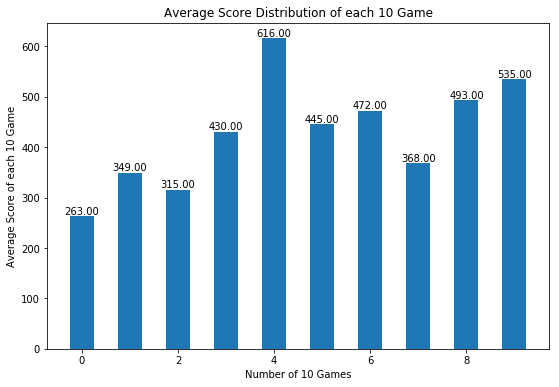

In [25]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

#  plot the training result

import matplotlib.pyplot as plt
import numpy as np

# plot 100 traing game result
plt.figure(figsize=(12,6))
plt.bar(np.arange(len(reward_list)),reward_list)
plt.xlabel("Number of Games")
plt.ylabel("Score of each Game")
plt.title("Score distribution of each Game")
plt.savefig("Score.png",dpi = 500)
plt.show()

# plot average of every 10 games result
avg = []
for i in range(10):
    sum = 0
    for j in range(int(len(reward_list)/10)):
        sum += reward_list[10*i+j]
    avg.append(sum/10)
# print(avg)
plt.figure(figsize=(9,6))
plt.bar(np.arange(len(avg)),avg, width = 0.5)
for x,y in zip(np.arange(len(avg)),avg):  
    plt.text(x,y+0.05,'%.2f' % y,ha='center',va='bottom')  
plt.xlabel("Number of 10 Games")
plt.ylabel("Average Score of each 10 Game")
plt.title("Average Score Distribution of each 10 Game")
plt.savefig("average_score.png", dpi = 500)
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 3".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (5 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       1: I can barely understand what data they are trying to collect/process
       2: I can barely understand why the data is relevant to the problem
       3: the data are relevant to the problem, but better data can be collected
       4: the data collected are relevant and at a proper scale
       5: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the exploration task (15 points):
       0: missing answer
       5: okay, but with major problems
      10: good, but with minor problems
      15: perfect
    
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


